## 실습: word2vec 실습 
NSMC 데이터세에서 word2vec 의미를 이해한다
- skip-gram
- cbow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#!pip install koreanize-matplotlib
#!pip install konlpy
import koreanize_matplotlib
from collections import Counter
from konlpy.tag import Okt

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import numpy as np
import time

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/nsmc.txt", sep="\t")

df.head()
# 단어 수 기준으로 정렬
df['word_count'] = df['document'].apply(lambda x: len(str(x).split()))
df_sorted = df.sort_values(by='word_count', ascending=False).reset_index(drop=True)
df_sorted.head()

,id,document,label,word_count
0,6928782,민좆 파쇼 쌕기들이 종교랑 같이 까는 수준 좀 보솤ㅋㅋㅋㅋㅋ 암 그라제! 우덜이 미...,0,41
1,9614878,나 진짜 웬만해선 다 재밌게 보는 편인데 진짜 보는 내내 언제 끝나나 개답답했다. ...,0,40
2,8330404,정유미 정준영 부부&막둥이 부부 땜 에 봐요 윤한부부 나오면 바로 다른 채널로 사상...,0,40
3,8153927,황당한 소재 및 전개. 쓰레기같은 스토리. 그 수준을 초월한 CG. 정말 어느 것 ...,0,40
4,8525988,EQ 측정용 영화임. 별 2개 - 당신은 마음이 아직 여린 편. 별 3개 - 남에게...,0,40


In [3]:
df=df_sorted[:2000].copy()
df.head()

,id,document,label,word_count
0,6928782,민좆 파쇼 쌕기들이 종교랑 같이 까는 수준 좀 보솤ㅋㅋㅋㅋㅋ 암 그라제! 우덜이 미...,0,41
1,9614878,나 진짜 웬만해선 다 재밌게 보는 편인데 진짜 보는 내내 언제 끝나나 개답답했다. ...,0,40
2,8330404,정유미 정준영 부부&막둥이 부부 땜 에 봐요 윤한부부 나오면 바로 다른 채널로 사상...,0,40
3,8153927,황당한 소재 및 전개. 쓰레기같은 스토리. 그 수준을 초월한 CG. 정말 어느 것 ...,0,40
4,8525988,EQ 측정용 영화임. 별 2개 - 당신은 마음이 아직 여린 편. 별 3개 - 남에게...,0,40


In [4]:
df.replace("", float("NaN"), inplace=True)
df = df.dropna().reset_index(drop=True)
print('결측치 처리 이후:',len(df))

df = df.drop_duplicates(['document']).reset_index(drop=True)
print('중복 제거 이후:',len(df))

df['document'] = df['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
print('한글 아닌 문자 제거 이후:',len(df))

df['document'] = df['document'].apply(lambda x: ' '.join([token for token in x.split() if len(token) > 2]))
print('리뷰 길이가 짧은 것 제거 :',len(df))

결측치 처리 이후: 2000
중복 제거 이후: 1998
한글 아닌 문자 제거 이후: 1998
리뷰 길이가 짧은 것 제거 : 1998


In [5]:
df.head()

,id,document,label,word_count
0,6928782,쌕기들이 종교랑 보솤ㅋㅋㅋㅋㅋ 그라제 우덜이 미군이 써보지도 완전히 전쟁도 있었당께...,0,41
1,9614878,웬만해선 재밌게 편인데 끝나나 개답답했다 그래도 지나면 재밌겠지 했는데 시나리오가 ...,0,40
2,8330404,정유미 정준영 부부막둥이 윤한부부 나오면 채널로 최초로 부부가 재미없음 막둥이 윤한...,0,40
3,8153927,황당한 쓰레기같은 스토리 수준을 초월한 칭찬해 차라리 디워는 나와서 신기하기라도 도...,0,40
4,8525988,측정용 영화임 당신은 마음이 남에게 상처를 못하는 당신은 인문학예술은 당신의 분야가...,0,40


In [6]:
okt = Okt()
def token_count(text):
    tokens = okt.morphs(text, stem=True)
    return len(tokens)

# 토큰 개수가 3개 이상인 문장만 남김
df = df[df['document'].apply(lambda x: token_count(x) >= 3)].reset_index(drop=True)
print("짧은 문장 제거 후:", len(df))

짧은 문장 제거 후: 1998


In [7]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
def clean_tokenize(text):
    tokens = okt.morphs(text, stem=True)
    return [word for word in tokens if word not in stopwords]

df['tokens'] = df['document'].apply(clean_tokenize)
print(df['tokens'].head())

0    [쌕기, 종교, 랑, 보솤, ㅋㅋㅋㅋㅋ, 그, 라, 제, 우, 덜, 미군, 써다, ...
1    [웬만하다, 선, 재밌다, 편, 인데, 끝나다, 개, 답답하다, 그래도, 지나다, ...
2    [정유미, 정준영, 부부, 막둥이, 윤한, 부부, 나오다, 채널, 로, 최초, 로,...
3    [황당하다, 쓰레기, 같다, 스토리, 수준, 을, 초월, 칭찬, 차라리, 디워, 나...
4    [측정, 용, 영화, 임, 당신, 마음, 남, 에게, 상처, 못, 당신, 인문학, ...
Name: tokens, dtype: object


In [8]:
df.head()

,id,document,label,word_count,tokens
0,6928782,쌕기들이 종교랑 보솤ㅋㅋㅋㅋㅋ 그라제 우덜이 미군이 써보지도 완전히 전쟁도 있었당께...,0,41,"[쌕기, 종교, 랑, 보솤, ㅋㅋㅋㅋㅋ, 그, 라, 제, 우, 덜, 미군, 써다, ..."
1,9614878,웬만해선 재밌게 편인데 끝나나 개답답했다 그래도 지나면 재밌겠지 했는데 시나리오가 ...,0,40,"[웬만하다, 선, 재밌다, 편, 인데, 끝나다, 개, 답답하다, 그래도, 지나다, ..."
2,8330404,정유미 정준영 부부막둥이 윤한부부 나오면 채널로 최초로 부부가 재미없음 막둥이 윤한...,0,40,"[정유미, 정준영, 부부, 막둥이, 윤한, 부부, 나오다, 채널, 로, 최초, 로,..."
3,8153927,황당한 쓰레기같은 스토리 수준을 초월한 칭찬해 차라리 디워는 나와서 신기하기라도 도...,0,40,"[황당하다, 쓰레기, 같다, 스토리, 수준, 을, 초월, 칭찬, 차라리, 디워, 나..."
4,8525988,측정용 영화임 당신은 마음이 남에게 상처를 못하는 당신은 인문학예술은 당신의 분야가...,0,40,"[측정, 용, 영화, 임, 당신, 마음, 남, 에게, 상처, 못, 당신, 인문학, ..."


In [9]:
print('리뷰의 최대 길이 :',max(len(review) for review in df['tokens']))
print('리뷰의 평균 길이 :',sum(map(len, df['tokens']))/len(df['tokens']))

리뷰의 최대 길이 : 46
리뷰의 평균 길이 : 28.24974974974975


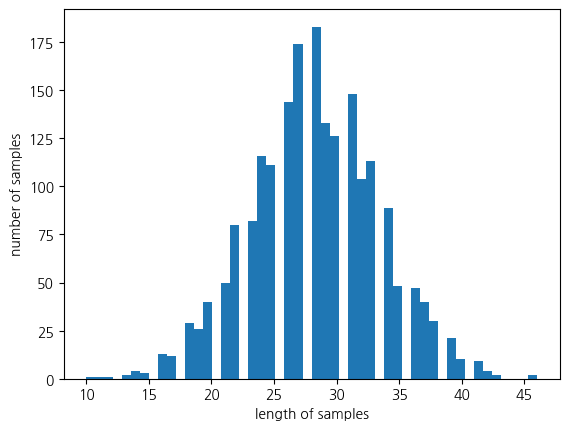

In [10]:
plt.hist([len(review) for review in df['tokens']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
import time
from gensim.models import Word2Vec

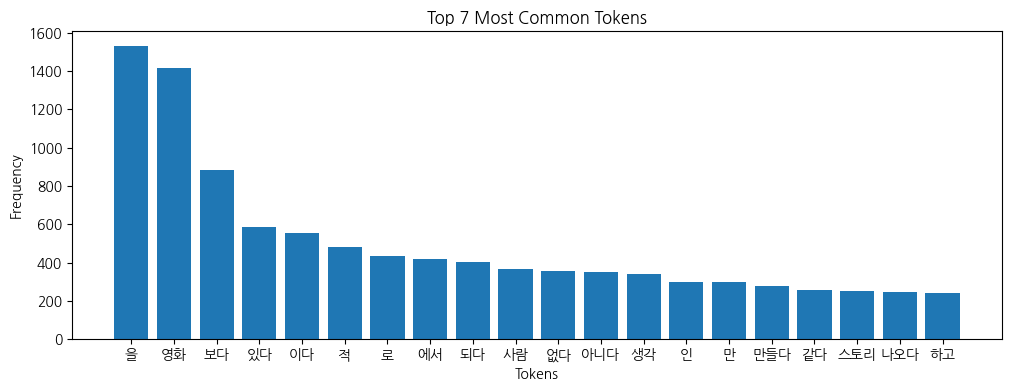

In [12]:

df_samples=df['tokens']
all_tokens = [token for tokens in df_samples for token in tokens]
#토큰별 등장 빈도 계산
counter = Counter(all_tokens)
common_words = counter.most_common(20) 
words, freqs = zip(*common_words)

plt.figure(figsize=(12,4))
plt.bar(words, freqs)
plt.title("Top 7 Most Common Tokens")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

In [13]:
list_tokens = list(df['tokens'])

In [14]:
start = time.time()
model  = Word2Vec(list_tokens, vector_size=100, window=3, min_count=1, sg=1)
elapsed_time = time.time() - start
print(f"[Skip-gram] 학습 시간: {elapsed_time:.4f}초")

[Skip-gram] 학습 시간: 0.9577초


In [15]:
target_word = '사람'
print('target_word:',target_word)
print(f"\n'{target_word}' 벡터:\n", model.wv[target_word])

target_word: 사람

'사람' 벡터:
 [-0.09219519  0.31271523  0.04235157  0.11385854 -0.00222401 -0.44315362
  0.17322595  0.5401837  -0.2613425  -0.11891062 -0.03387661 -0.3665122
 -0.12560584  0.21889198 -0.03852016 -0.16627522  0.05624998 -0.25732443
  0.06400202 -0.45754302  0.195026    0.11563436  0.2395557  -0.25504982
 -0.10919949  0.0051401  -0.29479244 -0.03852773 -0.22603826  0.04562685
  0.33957607 -0.06270503  0.18278515 -0.21886262 -0.08032915  0.3060417
  0.00445169 -0.07703203 -0.0679222  -0.3814986   0.08629185 -0.27166012
 -0.09790438  0.02579051  0.12830614 -0.15786548 -0.11369622 -0.01188196
  0.25019267  0.19923347  0.18061596 -0.28310388 -0.07449053  0.02326879
 -0.01850856  0.11506518  0.05342651  0.05122949 -0.30603582  0.1206037
  0.11603799  0.07107354  0.09170082 -0.03519065 -0.3006847   0.32105073
  0.16433248  0.27547413 -0.35692412  0.32253903 -0.18601914  0.10422906
  0.35275355 -0.09285344  0.36006403  0.07635786  0.00731103  0.01422167
 -0.2178242   0.1493899  -0

### 실습(1): 아래 셀에 교재에 있는 실습코드를 추가해세요.

In [19]:
## 여기에 코드 작성



In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_word2vec_cbow_vs_skipgram(model_cbow, model_sg, base_word='배우', topn=10):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    # base_word 체크
    if base_word not in model_cbow.wv or base_word not in model_sg.wv:
        print(f"'{base_word}' 단어가 두 모델의 vocabulary에 모두 있어야 합니다.")
        return

    # 유사 단어 추출
    words_cbow = [base_word] + [w for w, _ in model_cbow.wv.most_similar(base_word, topn=topn)]
    vecs_cbow = np.array([model_cbow.wv[w] for w in words_cbow])

    words_sg = [base_word] + [w for w, _ in model_sg.wv.most_similar(base_word, topn=topn)]
    vecs_sg = np.array([model_sg.wv[w] for w in words_sg])

    # 벡터 결합
    combined_vecs = np.vstack([vecs_cbow, vecs_sg])
    perplexity = min(30, len(combined_vecs) - 1)

    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, init='pca', learning_rate=100)
    reduced = tsne.fit_transform(combined_vecs)

    reduced_cbow = reduced[:len(words_cbow)]
    reduced_sg = reduced[len(words_cbow):]

    # Plot
    plt.figure(figsize=(7,5))

    # CBOW 점
    for i, word in enumerate(words_cbow):
        x, y = reduced_cbow[i]
        if word == base_word:
            plt.scatter(x, y, color='blue', marker='*', s=250, label='CBOW (base_word)' if i == 0 else "")
        else:
            plt.scatter(x, y, color='blue', marker='o', s=80, alpha=0.6)
        plt.annotate(word, (x + 0.5, y + 0.5), fontsize=8, color='blue')

    # Skip-gram 점
    for i, word in enumerate(words_sg):
        x, y = reduced_sg[i]
        if word == base_word:
            plt.scatter(x, y, color='red', marker='*', s=250, label='Skip-gram (base_word)' if i == 0 else "")
        else:
            plt.scatter(x, y, color='red', marker='o', s=80, alpha=0.6)
        plt.annotate(word, (x + 0.5, y + 0.5), fontsize=8, color='red')

    plt.title(f"CBOW vs Skip-gram Word2Vec TSNE 비교 (기준 단어: '{base_word}')", fontsize=10)
    plt.legend(frameon=False)
    plt.grid(False)
    plt.show()

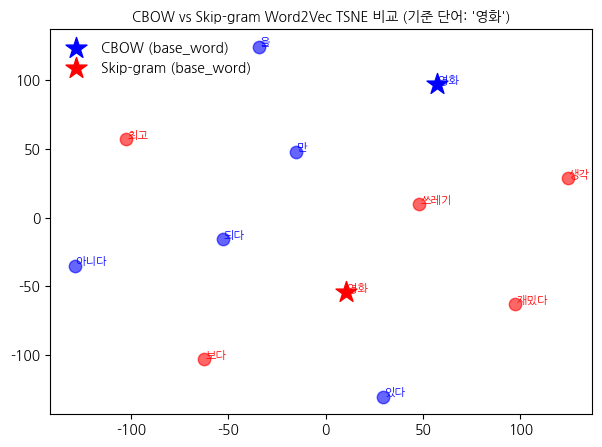

In [18]:
target_word = '영화'

model_cbow = Word2Vec(list_tokens, vector_size=100, window=3, min_count=1, sg=0)

model_sg = Word2Vec(list_tokens, vector_size=100, window=3, min_count=1, sg=1)

visualize_word2vec_cbow_vs_skipgram( model_cbow, model_sg, base_word=target_word,  topn=5)


### 실습2 : 교재에 있는 실습 코들를 작성하세요. 


In [20]:
target_word = '사람'
## 아래에 코드를 추가하세요
